In [ ]:
import fastparquet
import pandas as pd
import matplotlib.pyplot as plt
import underthesea
from collections import Counter
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from joblib import dump

## ĐỌC DỮ LIỆU

In [ ]:
import fastparquet
import pandas as pd
# Mở tệp Parquet
pf1 = fastparquet.ParquetFile('/content/drive/MyDrive/data_ML_20232/FINAL_DATA.parquet')
df1 = pf1.to_pandas()

## TRỰC QUAN HÓA DỮ LIỆU


In [4]:
label_counts = df1['label'].value_counts()
print(label_counts)

label
Kinh doanh    43326
Thể thao      42018
Pháp luật     42000
Thế giới      41997
Sức khỏe      41955
Name: count, dtype: int64


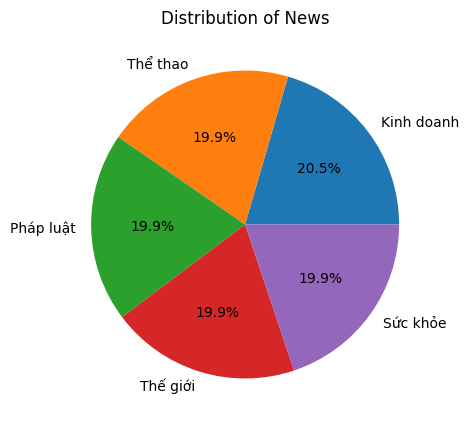

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
x_list = df1['combined_text']
y_list = df1['label']


# Tính toán số lượng mỗi nhãn trong y_list
counts = pd.Series(y_list).value_counts()

# Vẽ biểu đồ pie
plt.figure(figsize=(7, 5))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribution of News')
plt.show()


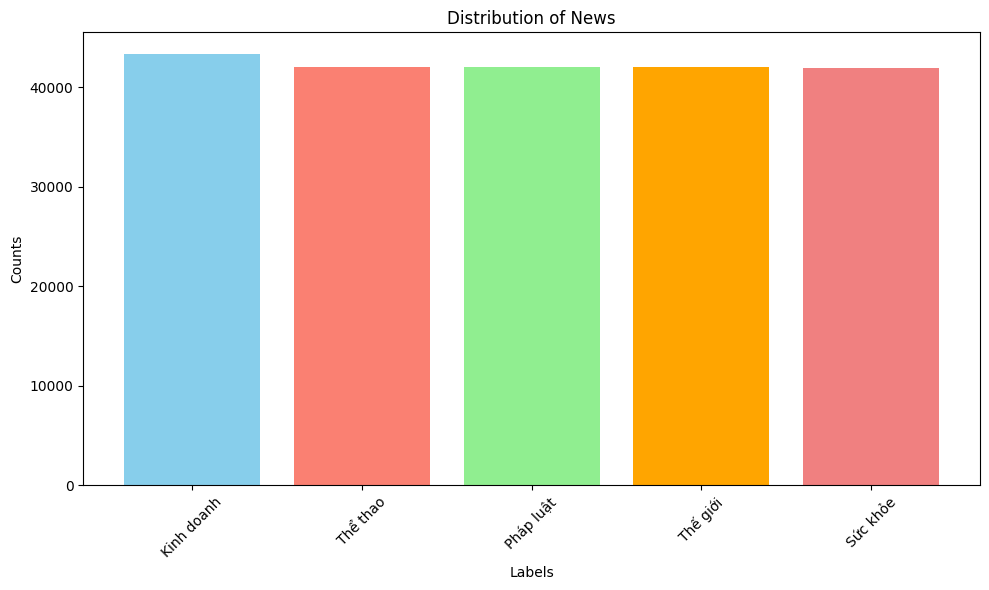

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử df1 là DataFrame của bạn
x_list = df1['combined_text']
y_list = df1['label']

# Tính toán số lượng mỗi nhãn trong y_list
counts = pd.Series(y_list).value_counts()

# Màu cho từng cột
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'lightcoral']  # Thay đổi màu theo ý muốn

# Vẽ biểu đồ bar
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values, color=colors)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of News')
plt.xticks(rotation=45)  # Xoay nhãn x nếu cần
plt.tight_layout()  # Đảm bảo các nhãn không bị trùng lên nhau
plt.show()


In [10]:
df1.describe()


,label,combined_text
count,211296,211296
unique,5,211296
top,Kinh doanh,Nỗ lực phe Dân chủ thách thức phiếu đại cử tri...
freq,43326,1


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211296 entries, 248523 to 241671
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   label          211296 non-null  object
 1   combined_text  211296 non-null  object
dtypes: object(2)
memory usage: 4.8+ MB


In [11]:
df1.shape

(211296, 2)

In [12]:
df1.columns


Index(['label', 'combined_text'], dtype='object')

In [13]:
df1.isnull()


,label,combined_text
248523,False,False
143412,False,False
154382,False,False
246340,False,False
329014,False,False
...,...,...
96106,False,False
172974,False,False
589354,False,False
13892,False,False


In [14]:
df1.dtypes


label            object
combined_text    object
dtype: object

## TIỀN XỬ LÝ DỮ LIỆU

In [15]:
df1['msg_lower']= df1['combined_text'].apply(lambda x: x.lower())
#library that contains punctuation
import string
string.punctuation
#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df1['clean_msg']= df1['msg_lower'].apply(lambda x:remove_punctuation(x))


In [17]:
import underthesea
df1['tokenized']= df1['clean_msg'].apply(lambda x:underthesea.word_tokenize(x))

In [35]:
stopwords = {
    "bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa", "chuyện", "có",
    "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều", "điều", "do",
    "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "một_cách", "này",
    "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nơi", "nữa", "phải", "qua", "ra", "rằng",
    "rất", "rồi", "sau", "sẽ", "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng", "và",
    "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa", "ở", "trong", "vnexpress", "có thể"
}

def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output
#applying the function
df1['no_stopwords']= df1['tokenized'].apply(lambda x:remove_stopwords(x))

## TRỰC QUAN HÓA DỮ LIỆU THEO TỪNG NHÃN

In [36]:
import pandas as pd
from collections import Counter

# Giả sử df là DataFrame chứa cột df1[tokenize] và cột nhãn label
# df = ...

# Tạo một từ điển để lưu trữ các từ phổ biến cho mỗi nhãn
top_words_by_label = {}

# Lặp qua mỗi nhãn
for label in ['Kinh doanh', 'Pháp luật', 'Sức khỏe', 'Thế giới', 'Thể thao']:
    # Lấy các từ tokenize tương ứng với nhãn
    words_for_label = df1[df1['label'] == label]['no_stopwords']

    # Kết hợp tất cả các từ tokenize trong mỗi nhãn thành một danh sách duy nhất, loại bỏ từ 'vnexpress'
    all_words = [word for sublist in words_for_label for word in sublist]

    # Sử dụng Counter để đếm số lần xuất hiện của mỗi từ
    word_counts = Counter(all_words)

    # Lấy 10 từ xuất hiện nhiều nhất
    top_words = word_counts.most_common(10)

    # Lưu trữ danh sách các từ phổ biến cho mỗi nhãn
    top_words_by_label[label] = top_words

# In ra kết quả
for label, top_words in top_words_by_label.items():
    print(f"Top 10 từ phổ biến trong nhãn '{label}':")
    for word, count in top_words:
        print(f"- {word}: {count} lần")


Top 10 từ phổ biến trong nhãn 'Kinh doanh':
- năm: 11239 lần
- đồng: 9366 lần
- tỷ: 8495 lần
- tăng: 8437 lần
- việt nam: 8138 lần
- doanh nghiệp: 7142 lần
- giá: 6449 lần
- hơn: 6418 lần
- một: 5993 lần
- giảm: 5417 lần
Top 10 từ phổ biến trong nhãn 'Pháp luật':
- người: 20403 lần
- công an: 14239 lần
- vụ: 10576 lần
- tuổi: 10141 lần
- đối tượng: 8695 lần
- bắt: 8503 lần
- đồng: 8392 lần
- tỉnh: 8239 lần
- về: 8057 lần
- một: 7847 lần
Top 10 từ phổ biến trong nhãn 'Sức khỏe':
- người: 14499 lần
- tuổi: 10745 lần
- covid19: 8465 lần
- bệnh: 7682 lần
- ca: 6725 lần
- ngày: 6652 lần
- một: 6414 lần
- bệnh viện: 6045 lần
- y tế: 5929 lần
- bệnh nhân: 5900 lần
Top 10 từ phổ biến trong nhãn 'Thế giới':
- người: 14522 lần
- trung quốc: 10603 lần
- nga: 10137 lần
- mỹ: 10062 lần
- một: 7017 lần
- ukraine: 6963 lần
- nước: 5916 lần
- tổng thống: 5842 lần
- trump: 5740 lần
- về: 5543 lần
Top 10 từ phổ biến trong nhãn 'Thể thao':
- trận: 11123 lần
- anh: 10914 lần
- vòng: 10354 lần
- hlv: 9448 

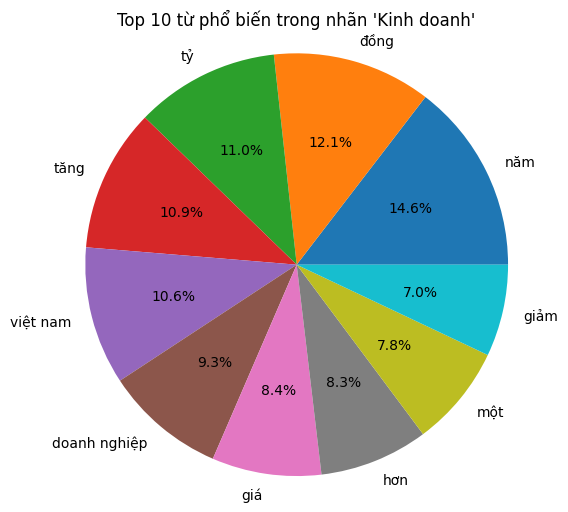

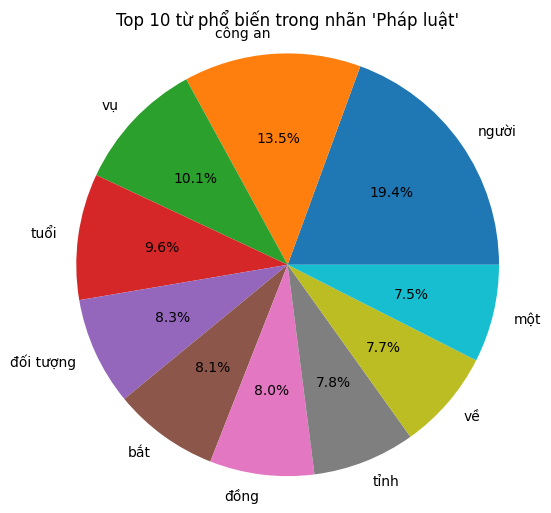

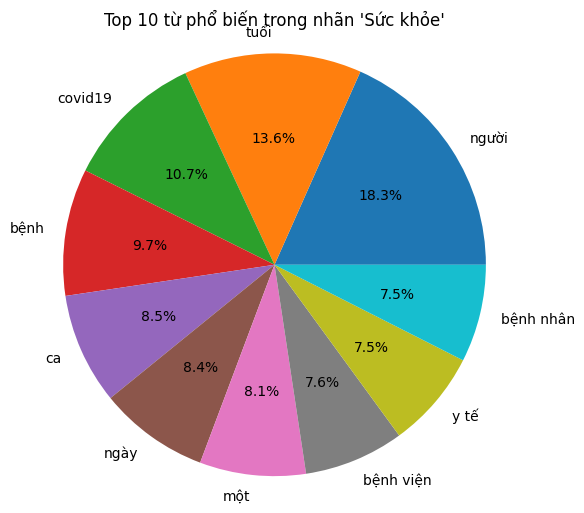

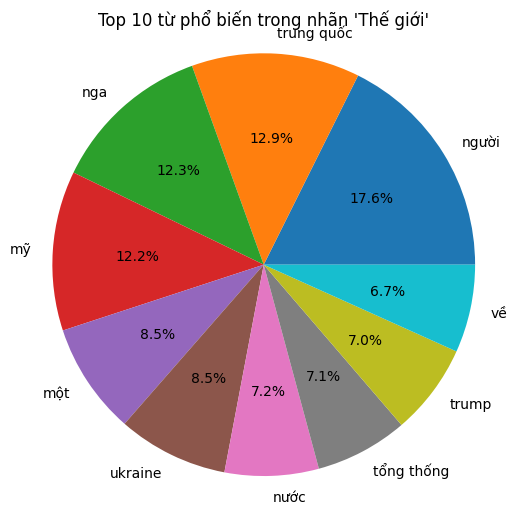

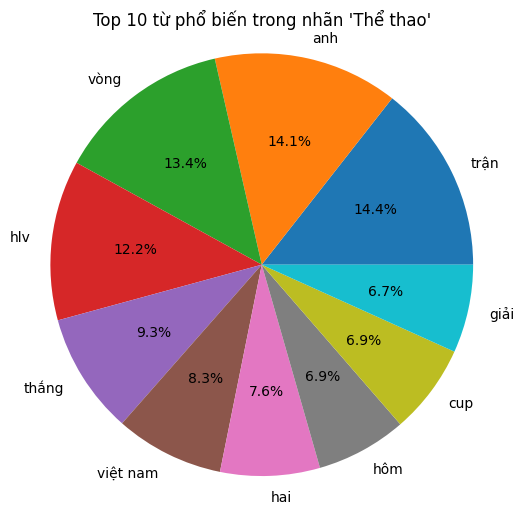

In [37]:
for label, top_words in top_words_by_label.items():
    plt.figure(figsize=(6, 6))
    plt.pie([count for word, count in top_words], labels=[word for word, count in top_words], autopct='%1.1f%%')
    plt.title(f"Top 10 từ phổ biến trong nhãn '{label}'")
    plt.axis('equal')
    plt.show()

## VECTOR HÓA VĂN BẢN

In [39]:
  from gensim.models import Word2Vec
  #from nltk.tokenize import word_tokenize
  import numpy as np
  import pandas as pd


  # Tokenize các câu văn bản đã được lemmatized
  tokenized_text = df1['no_stopwords']

  # Huấn luyện mô hình Word2Vec với CBOW (sg=0)
  word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=200, window=10, min_count=1, sg=0)

  # Hàm tạo vector văn bản bằng cách lấy trung bình các vector từ
  def vectorize_document(doc, model):
      vectorized_doc = [model.wv[word] for word in doc if word in model.wv]
      return np.mean(vectorized_doc, axis=0) if vectorized_doc else np.zeros(model.vector_size)

  # Vector hóa tất cả tài liệu
  vectorized_text = np.array([vectorize_document(doc, word2vec_model) for doc in tokenized_text])

  # In ra kích thước của ma trận vector hóa
  print("Shape of vectorized matrix:", vectorized_text.shape)

  # In ra các từ vựng đã được vector hóa
  print("Vocabulary:", list(word2vec_model.wv.key_to_index.keys()))

  # In ra ma trận vector hóa
  print("Vectorized Matrix:", vectorized_text)


Shape of vectorized matrix: (211296, 200)
Vocabulary: ['người', 'một', 'năm', 'về', 'ngày', 'tuổi', 'đến', 'hơn', 'hai', 'anh', 'việt nam', 'đồng', 'covid19', 'trung quốc', 'tăng', 'giúp', 'tiền', 'ông', 'làm', 'công an', 'triệu', 'tháng', 'mỹ', 'vụ', 'nhà', 'nhất', 'tp', 'nước', 'tỷ', 'hà nội', 'giảm', 'trận', 'mới', 'gần', 'đi', 'hàng', 'nga', 'vòng', 'tỉnh', 'khiến', 'hcm', 'bắt', 'gây', 'tôi', 'ba', 'ca', 'cao', 'số', 'hlv', 'lần', 'usd', 'con', 'công ty', 'biết', 'đầu', 'đối tượng', '2', 'cách', 'bệnh', 'tới', 'giá', '5', 'doanh nghiệp', 'bán', 'y tế', '3', 'chết', 'nhận', 'bệnh viện', 'dùng', 'ncov', '10', 'mua', 'thêm', 'thắng', 'phát hiện', '4', 'vaccine', 'thế giới', 'cảnh sát', 'bộ', 'lớn', 'bé', 'ukraine', 'ngân hàng', 'đường', 'hôm', 'nhóm', 'bằng', 'thứ', 'điều tra', 'trẻ', 'xe', 'giải', 'bệnh nhân', 'gái', 'nói', 'nhiễm', 'cựu', 'đưa', 'tổng thống', 'trump', 'còn', 'muốn', 'tối', 'huyện', 'loại', 'bác sĩ', '6', 'vàng', 'sáng', 'điểm', 'nay', 'tuần', 'án', 'nam', 'cuộc', '

## LABEL ENCODING CHO NHÃN

In [50]:
label_encoder = LabelEncoder()
y_list = label_encoder.fit_transform(y_list)
import numpy as np
from sklearn.utils import shuffle
y = np.asarray(y_list, dtype=np.float32)



print("Shape of feature matrix X")
print(vectorized_text.shape)
print("\nShape of label matrix Y")
print(y.shape)

class_types, counts = np.unique(y, return_counts=True)

print("\nClass labels")
print(class_types)
print("\nClass counts")
print(counts)

Shape of feature matrix X
(211296, 200)

Shape of label matrix Y
(211296,)

Class labels
[0. 1. 2. 3. 4.]

Class counts
[43326 42000 41955 41997 42018]


In [43]:
original_labels = label_encoder.classes_
for index, label in enumerate(original_labels):
    print(f"{index}: {label}")

0: Kinh doanh
1: Pháp luật
2: Sức khỏe
3: Thế giới
4: Thể thao


## PHÂN CHIA TẬP TRAIN/VAL/TEST

In [51]:
from sklearn.model_selection import train_test_split

# Phân chia dữ liệu thành tập train (70%) và tập gộp (30%)
x_trainval, x_test, y_trainval, y_test = train_test_split(vectorized_text, y, test_size=0.2, stratify = y, random_state=42)

# Phân chia tập gộp thành tập train (80% của tập gộp) và tập validation (20% của tập gộp)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.125, stratify = y_trainval, random_state=42)

print(x_trainval.shape)
print(y_trainval.shape)

(169036, 200)
(169036,)


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class ConfusionMatrixPlot:
    def __init__(self, labels, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.labels = labels
    def plot(self):
        conf_matrix = confusion_matrix(y_true=self.y_true, y_pred=self.y_pred)
        plt.figure(figsize = (10,10))
        ## vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=self.labels)
        ## vis.plot(cmap="Blues")
        sns.heatmap(conf_matrix, annot=True, linecolor = 'black' , linewidth = 1, fmt='', cmap="Blues", xticklabels = self.labels , yticklabels = self.labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix Of Best Model')
        plt.show()

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
class ClassificationReportPlot:
    def __init__(self,labels, true_labels, predicted_labels):
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.labels = labels
    def plot(self):
        report = classification_report(self.true_labels, self.predicted_labels, target_names=labels, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        pd.set_option("display.max_rows", None)
        report_df.style.set_properties(**{'border-color': 'black', 'border-style': 'solid'})
        display(report_df)
        plt.show()

## LOGISTIC REGRESSION

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best Model: LogisticRegression(solver='liblinear')


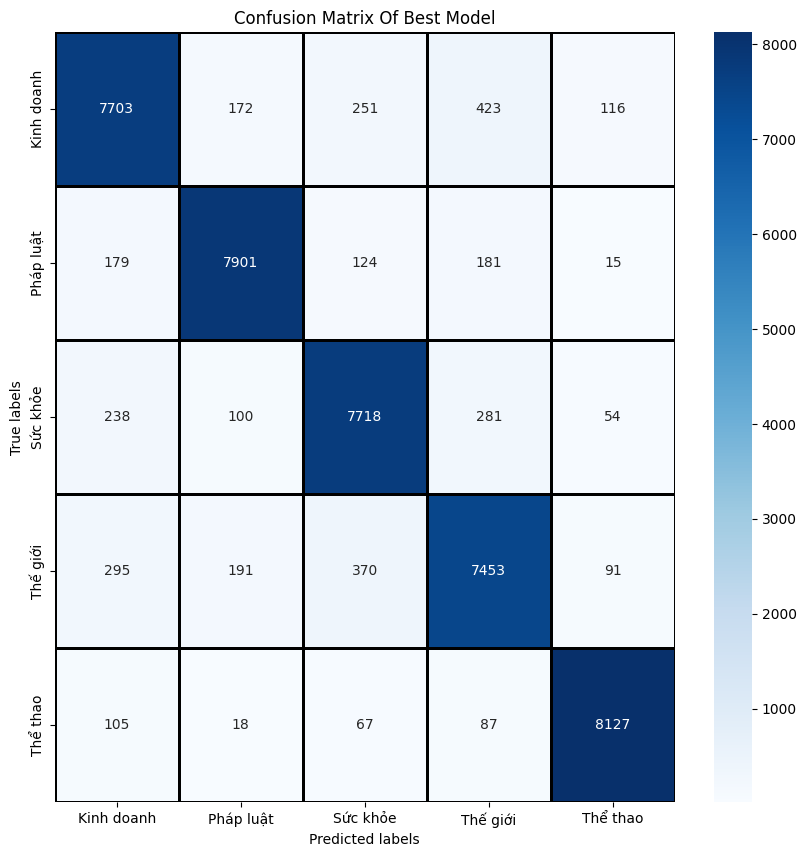

,precision,recall,f1-score,support
Kinh doanh,0.904108,0.888979,0.896479,8665.00000
Pháp luật,0.942615,0.940595,0.941604,8400.00000
Sức khỏe,0.904807,0.919795,0.912239,8391.00000
Thế giới,0.884629,0.887262,0.885944,8400.00000
Thể thao,0.967155,0.967040,0.967097,8404.00000
accuracy,0.920540,0.920540,0.920540,0.92054
macro avg,0.920663,0.920734,0.920673,42260.00000
weighted avg,0.920567,0.920540,0.920527,42260.00000


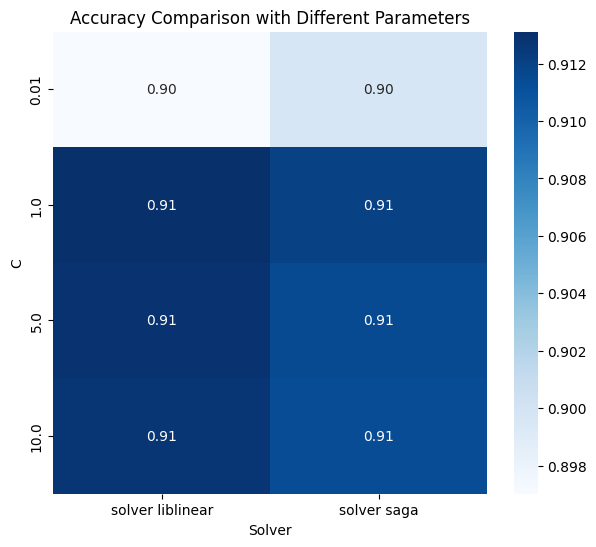

In [29]:
labels = ['Kinh doanh','Pháp luật','Sức khỏe','Thế giới','Thể thao']
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
param_grid = {
    'C': [0.01, 1.0, 5.0, 10.0],
    'solver': ['liblinear', 'saga'],
}
logistic_regression = LogisticRegression()
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model1 = grid_search.best_estimator_
print("Best Model:", best_model1)
best_model1.fit(x_trainval, y_trainval)
y_pred = best_model1.predict(x_test)
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(
    np.array(mean_test_scores).reshape(len(param_grid['C']), len(param_grid['solver'])),
    index=[f'{i}' for i in param_grid['C']],
    columns=[f'solver {j}' for j in param_grid['solver']])
plt.figure(figsize=(7, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Solver')
plt.ylabel('C')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()

In [30]:
from joblib import dump
dump(best_model1, '/content/drive/MyDrive/data_ML_20232/LogisticRegression_0306.joblib')

['/content/drive/MyDrive/data_ML_20232/LogisticRegression_0306.joblib']

## RANDOM FOREST

Best Model: RandomForestClassifier(max_depth=20, n_estimators=300)


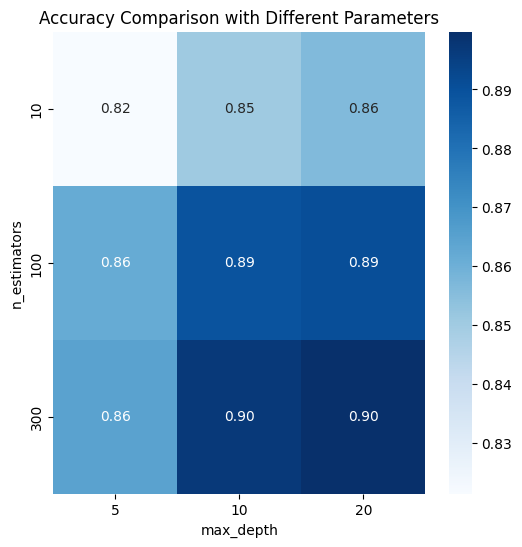

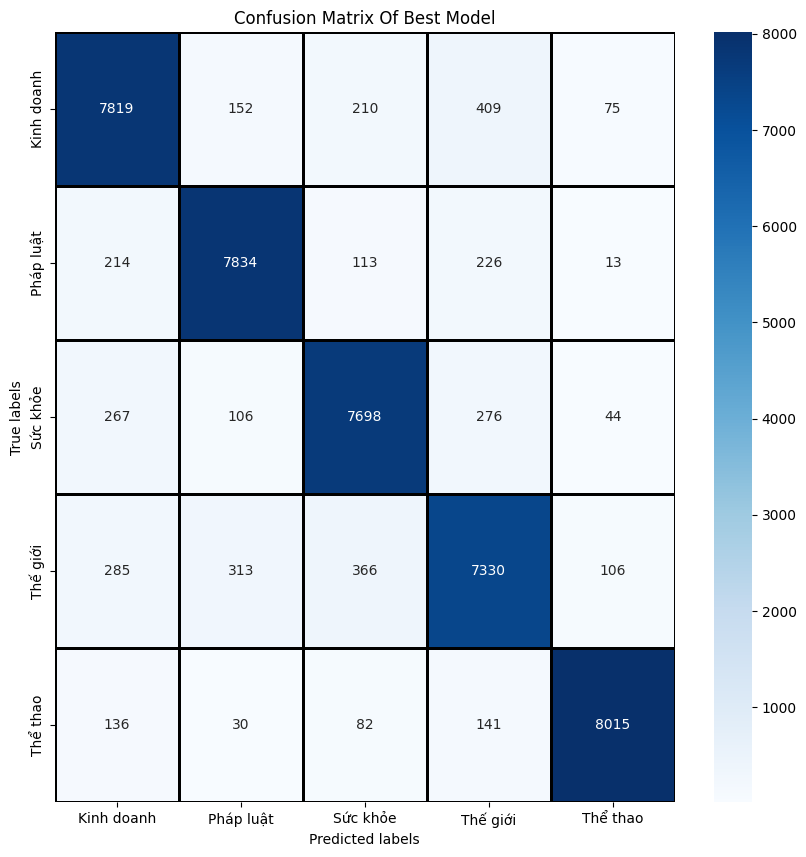

,precision,recall,f1-score,support
Kinh doanh,0.896571,0.902366,0.899459,8665.000000
Pháp luật,0.928749,0.932619,0.930680,8400.000000
Sức khỏe,0.908962,0.917412,0.913167,8391.000000
Thế giới,0.874493,0.872619,0.873555,8400.000000
Thể thao,0.971162,0.953713,0.962358,8404.000000
accuracy,0.915665,0.915665,0.915665,0.915665
macro avg,0.915988,0.915746,0.915844,42260.000000
weighted avg,0.915873,0.915665,0.915746,42260.000000


In [31]:
labels = ['Kinh doanh','Pháp luật','Sức khỏe','Thế giới','Thể thao']
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
param_grid = {
    'n_estimators': [10, 100, 300],
    'max_depth': [5, 10, 20],
}
random_forest = RandomForestClassifier()
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model3 = grid_search.best_estimator_
print("Best Model:", best_model3)
best_model3.fit(x_trainval, y_trainval)
y_pred = best_model3.predict(x_test)
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(
    np.array(mean_test_scores).reshape(len(param_grid['n_estimators']), len(param_grid['max_depth'])),
    index=[f'{i}' for i in param_grid['n_estimators']],
    columns=[f'{j}' for j in param_grid['max_depth']])
plt.figure(figsize=(6, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

In [32]:
from joblib import dump
dump(best_model3, '/content/drive/MyDrive/data_ML_20232/RandomForest_0306.joblib')

['/content/drive/MyDrive/data_ML_20232/RandomForest_0306.joblib']

## KNN

Best Model: KNeighborsClassifier(n_neighbors=15,
                     weights=<function weight2 at 0x7a2816957d00>)


<ipython-input-18-edc79238a5c7>:7: RuntimeWarning: divide by zero encountered in divide
  return 1 / distances**2


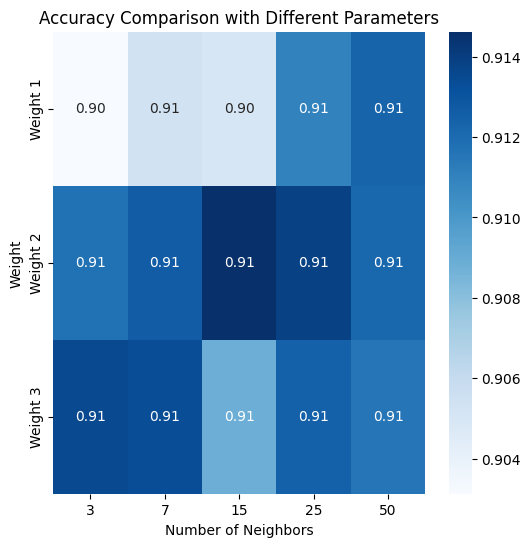

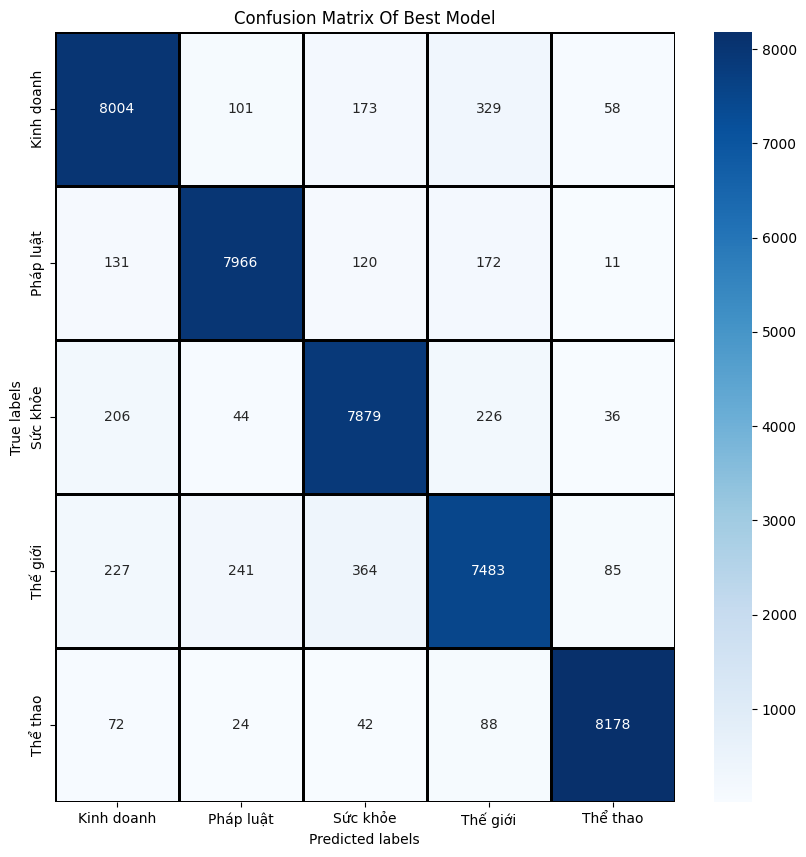

,precision,recall,f1-score,support
Kinh doanh,0.926389,0.923716,0.925051,8665.000000
Pháp luật,0.951051,0.948333,0.949690,8400.000000
Sức khỏe,0.918512,0.938982,0.928635,8391.000000
Thế giới,0.901784,0.890833,0.896275,8400.000000
Thể thao,0.977294,0.973108,0.975197,8404.000000
accuracy,0.934927,0.934927,0.934927,0.934927
macro avg,0.935006,0.934995,0.934969,42260.000000
weighted avg,0.934959,0.934927,0.934912,42260.000000


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
labels = ['Kinh doanh','Pháp luật','Sức khỏe','Thế giới','Thể thao']
def weight1(distances):
    return distances
def weight2(distances):
    return 1 / distances**2
def weight3(distances):
    return 1 / distances
param_grid = {
    'n_neighbors': [3, 7, 15, 25, 50],
    'weights': [weight1, weight2, weight3]
}
KNN = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=KNN, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model = grid_search.best_estimator_
print("Best Model:", best_model)
best_model.fit(x_trainval,y_trainval)
y_pred = best_model.predict(x_test)
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(mean_test_scores.reshape(len(param_grid['weights']), len(param_grid['n_neighbors'])),
                    index=[f'Weight {i+1}' for i in range(len(param_grid['weights']))],
                    columns=[f'{j}' for j in param_grid['n_neighbors']])
plt.figure(figsize=(6, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Number of Neighbors')
plt.ylabel('Weight')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

In [19]:
from joblib import dump
dump(best_model, '/content/drive/MyDrive/data_ML_20232/KNN_0306.joblib')

['/content/drive/MyDrive/data_ML_20232/KNN_0306.joblib']

## SVM

Best Model: SVC(C=15, gamma=0.002)


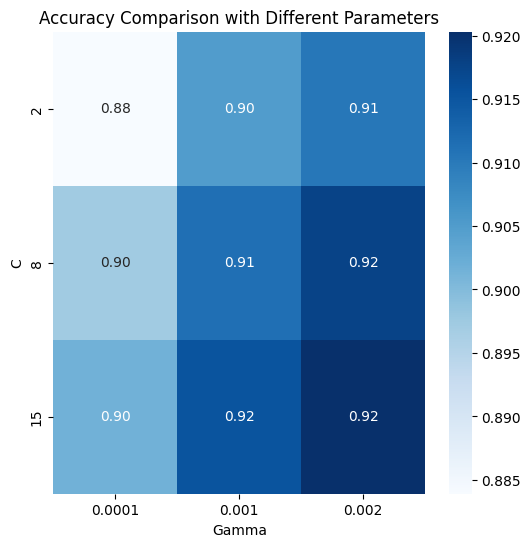

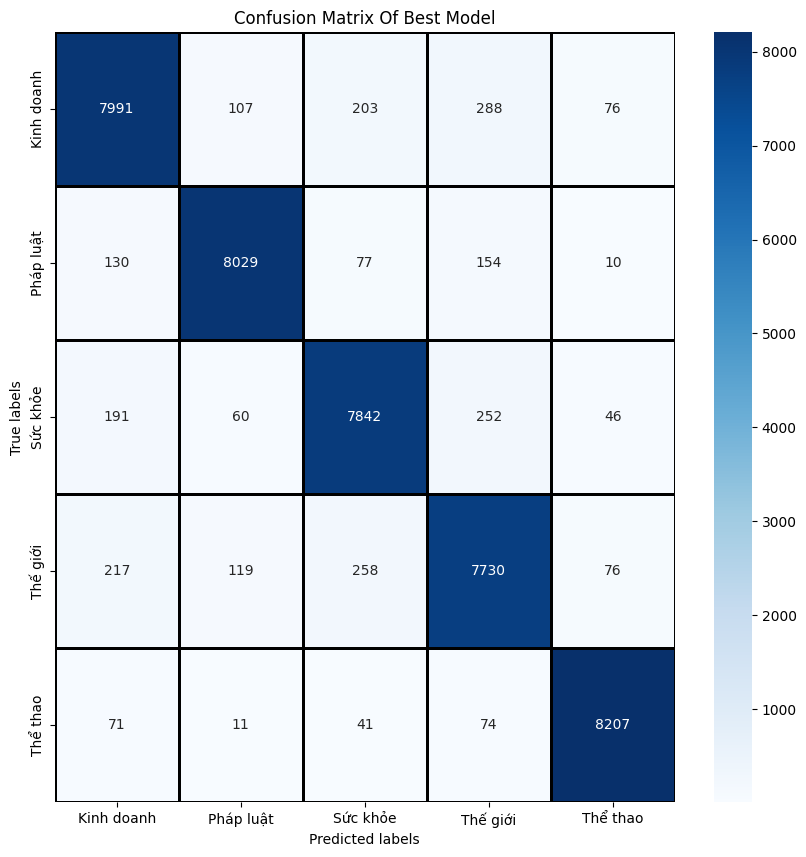

,precision,recall,f1-score,support
Kinh doanh,0.929186,0.922216,0.925688,8665.000000
Pháp luật,0.964329,0.955833,0.960062,8400.000000
Sức khỏe,0.931243,0.934573,0.932905,8391.000000
Thế giới,0.909626,0.920238,0.914901,8400.000000
Thể thao,0.975282,0.976559,0.975920,8404.000000
accuracy,0.941765,0.941765,0.941765,0.941765
macro avg,0.941933,0.941884,0.941895,42260.000000
weighted avg,0.941859,0.941765,0.941799,42260.000000


In [52]:
labels = ['Kinh doanh','Pháp luật','Sức khỏe','Thế giới','Thể thao']
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn import svm
param_grid = {'C': [2,8,15], 'gamma': [0.0001, 0.001, 0.002]}
svm = svm.SVC(kernel='rbf')
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_val, y_val)
best_model7 = grid_search.best_estimator_
print("Best Model:", best_model7)
best_model7.fit(x_trainval,y_trainval)
y_pred = best_model7.predict(x_test)
mean_test_scores = grid_search.cv_results_['mean_test_score']
parameters = grid_search.cv_results_['params']
data = pd.DataFrame(
    np.array(mean_test_scores).reshape(len(param_grid['C']), len(param_grid['gamma'])),
    index=[f'{i}' for i in param_grid['C']],
    columns=[f'{j}' for j in param_grid['gamma']])
plt.figure(figsize=(6, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuracy Comparison with Different Parameters')
plt.show()
confusion_plot = ConfusionMatrixPlot(labels, y_test, y_pred)
confusion_plot.plot()
report_plot = ClassificationReportPlot(labels, y_test, y_pred)
report_plot.plot()

In [54]:
from joblib import dump
dump(best_model7, '/content/drive/MyDrive/data_ML_20232/SVM_final_demo.joblib')

['/content/drive/MyDrive/data_ML_20232/SVM_final_demo.joblib']